In [34]:
import numpy as np
import pandas as pd
import json
import re
from sklearn.multiclass import OneVsRestClassifier

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

In [35]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

In [36]:
train["cuisine"].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [37]:
train["cuisine"].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

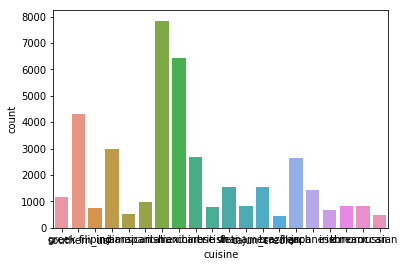

In [38]:
sns.countplot(x="cuisine", data=train)

In [39]:
train['num_ingredients'] = train['ingredients'].apply(lambda x: len(x))
test['num_ingredients'] = test['ingredients'].apply(lambda x: len(x))
train.sort_values(by=["num_ingredients"], ascending=True).head()

,cuisine,id,ingredients,num_ingredients
30636,spanish,32772,[sweetened condensed milk],1
13178,thai,29570,[grained],1
23512,french,35028,[haricots verts],1
22119,french,41135,[butter],1
18136,thai,39186,[jasmine rice],1


In [40]:
train = train[train['num_ingredients'] > 2]
train.sort_values(by=["num_ingredients"], ascending=True).head()

,cuisine,id,ingredients,num_ingredients
5857,japanese,251,"[sugar, mayonaise, garlic chili sauce]",3
36682,southern_us,6395,"[coconut syrup, half & half, diet dr. pepper]",3
34008,southern_us,36348,"[baby back ribs, spices, sauce]",3
23494,japanese,21333,"[brown rice, white rice, soy sauce]",3
34019,mexican,41619,"[processed cheese, chili powder, chili]",3


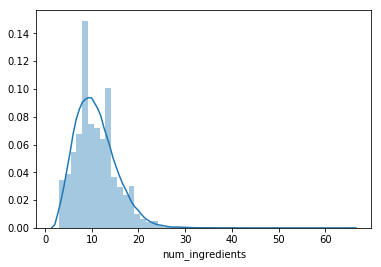

In [41]:
sns.distplot(train["num_ingredients"])

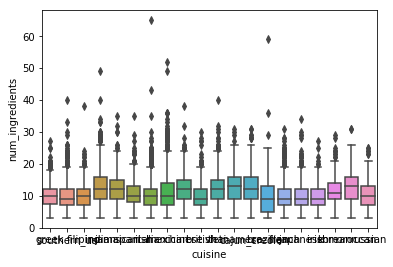

In [42]:
sns.boxplot(y="num_ingredients", x="cuisine", data=train)

In [43]:
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower()
    ingredients_text = ingredients_text.replace('-', '')#wasabe
    ingredients_text = ingredients_text.replace('wasabe', 'wasabi') #for wrong name
    ingredients_text = ingredients_text.replace('egg whites', 'eggwhites , egg , whites')
    ingredients_text = ingredients_text.replace('lime juice', 'limejuice')
    ingredients_text = ingredients_text.replace('clam juice', 'clamjuice')
    ingredients_text = ingredients_text.replace('lemon juice', 'lemonjuice')
    ingredients_text = ingredients_text.replace('orange juice', 'orangejuice')
    ingredients_text = ingredients_text.replace('soy sauce', 'soysauce')
    ingredients_text = ingredients_text.replace('fish sauce', 'fishsauce')
    ingredients_text = ingredients_text.replace('sesame oil', 'sesameoil')
    ingredients_text = ingredients_text.replace('olive oil', 'oliveoil')#vegetable oil corn oil
    ingredients_text = ingredients_text.replace('vegetable oil', 'vegetableoil')
    ingredients_text = ingredients_text.replace('corn oil', 'cornoil')#rice wine
    ingredients_text = ingredients_text.replace('coconut cream', 'coconutcream')
    ingredients_text = ingredients_text.replace('yellow onion', 'yellowonion')
    ingredients_text = ingredients_text.replace('cream cheese', 'creamcheese') 
    ingredients_text = ingredients_text.replace('baby spinach', 'babyspinach')
    ingredients_text = ingredients_text.replace('coriander seeds', 'corianderseeds')
    ingredients_text = ingredients_text.replace('corn tortillas', 'corntortillas')
    ingredients_text = ingredients_text.replace('rice cakes', 'ricecakes')
    words = []
    for word in ingredients_text.split():
        if re.findall('[0-9]', word): continue
        if len(word) <= 2: continue
        if '’' in word: continue
        word = lemmatizer.lemmatize(word)
        if len(word) > 0: words.append(word)
    return ' '.join(words)

In [44]:
train['ingredients_clean_string'] = [' , '.join(z).strip() for z in train['ingredients']]
train['x'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in train['ingredients']]       
test['ingredients_clean_string'] = [' , '.join(z).strip() for z in test['ingredients']]
test['x'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in test['ingredients']]       

In [45]:
train.head()

,cuisine,id,ingredients,num_ingredients,ingredients_clean_string,x
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,"romaine lettuce , black olives , grape tomatoe...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,"plain flour , ground pepper , salt , tomatoes ...",plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,"eggs , pepper , salt , mayonaise , cooking oil...",egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,"water , vegetable oil , wheat , salt",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,"black pepper , shallots , cornflour , cayenne ...",black pepper shallot cornflour cayenne pepper ...


In [46]:
vectorizer = make_pipeline(
    TfidfVectorizer(sublinear_tf=True),
    FunctionTransformer(lambda x: x.astype('float'), validate=False)
)

In [47]:
x_train = vectorizer.fit_transform(train['x'].values)
x_train.sort_indices()
x_test = vectorizer.transform(test['x'].values)

In [48]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['cuisine'].values)
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

In [49]:
estimator = SVC(C=250, # penalty parameter, setting it to a larger value 
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value, not tuned yet
	 			 gamma=1.4, # kernel coefficient, not tuned yet
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	 			 probability=False, # no need to enable probability estimates
	 			 cache_size=1000, # 200 MB cache size
	 			 class_weight=None, # all classes are treated equally 
	 			 verbose=False, # print the logs 
	 			 max_iter=-1, # no limit, let it run
	 			 decision_function_shape=None, # will use one vs rest explicitly 
	 			 random_state=None)
classifier = OneVsRestClassifier(estimator, n_jobs=-1)

In [50]:
classifier.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC(C=250, cache_size=1000, class_weight=None, coef0=1,
  decision_function_shape=None, degree=3, gamma=1.4, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=-1)

In [51]:
y_pred = label_encoder.inverse_transform(classifier.predict(x_test))
test['cuisine'] = y_pred
test[['id', 'cuisine']].to_csv('0114_4.csv', index=False)
test[['id', 'cuisine']].head()

,id,cuisine
0,18009,irish
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
